# 네이버 영화 리뷰 감성분류 모델 구현
- 데이터 전처리 : nsmc_preprocessing.ipynb

## 라이브러리 임포트

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 구글 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 학습 데이터 로드

In [3]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/nsmc/'

train_input = np.load(open(DATA_PATH + 'train_input.npy', 'rb'))
train_label = np.load(open(DATA_PATH + 'train_label.npy', 'rb'))
prepro_configs = json.load(open(DATA_PATH + 'data_configs.json', 'r'))

## 모델 하이퍼파라미터 정의

In [4]:
model_name = 'nsmc_cnn'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

## 모델 정의

In [5]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [6]:
model = CNNClassifier(**kargs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [7]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = DATA_PATH + '/weights_cnn.h5'
mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

## 모델 학습 
- GPU 사용 : 런타임 -> 런타임 유형 변경 -> GPU

In [8]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[es, mc])

Epoch 1/10
235/235 [==============================] - 48s 77ms/step - loss: 0.5437 - accuracy: 0.7034 - val_loss: 0.3950 - val_accuracy: 0.8199

Epoch 00001: val_accuracy improved from -inf to 0.81993, saving model to /content/drive/MyDrive/nlpdata/nsmc/weights_cnn.h5
Epoch 2/10
235/235 [==============================] - 17s 74ms/step - loss: 0.3549 - accuracy: 0.8446 - val_loss: 0.3875 - val_accuracy: 0.8266

Epoch 00002: val_accuracy improved from 0.81993 to 0.82663, saving model to /content/drive/MyDrive/nlpdata/nsmc/weights_cnn.h5
Epoch 3/10
235/235 [==============================] - 17s 73ms/step - loss: 0.2933 - accuracy: 0.8765 - val_loss: 0.3928 - val_accuracy: 0.8247

Epoch 00003: val_accuracy did not improve from 0.82663
Epoch 4/10
235/235 [==============================] - 17s 72ms/step - loss: 0.2486 - accuracy: 0.8974 - val_loss: 0.4139 - val_accuracy: 0.8191

Epoch 00004: val_accuracy did not improve from 0.82663


## 결과 플롯

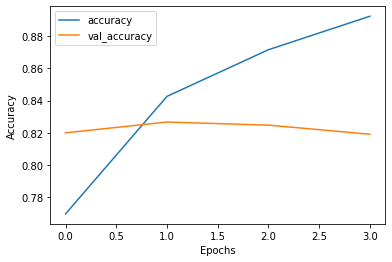

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## 모델 평가

In [12]:
test_input = np.load(open(DATA_PATH + 'test_input.npy', 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_PATH + 'test_label.npy', 'rb'))

model.load_weights(os.path.join(DATA_PATH, 'weights_cnn.h5'))

In [13]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 5s 3ms/step - loss: 0.3901 - accuracy: 0.8248


[0.39005014300346375, 0.8247600197792053]